# FarTrend Customer Segmentation and Recommendation System


## Background Story  

In the ever-evolving landscape of e-commerce, understanding customer behavior has become a cornerstone of strategic marketing. An emerging e-commerce giant, "FarTrend," has experienced rapid growth by offering a wide range of products from fashion to electronics, catering to over 3400 customers across diverse demographics. Despite their success, FarTrend faces challenges in personalizing marketing efforts and predicting future purchasing behavior, crucial for sustaining growth and enhancing customer satisfaction.

## The Challenge

FarTrend's extensive customer database reveals purchasing patterns over the past year but lacks actionable insights to anticipate the needs of new customers. Traditional marketing strategies have yielded moderate success; however, the leadership team believes that a more data-driven approach could unlock exponential growth.

You are working on the marketing intelligence team! Your goal is to develop a  machine learning model that segments FarTrend's customer base and predicts future purchases of new customers within their first year. This model aims to transform FarTrend approach to customer engagement by delivering personalized marketing campaigns and tailored product recommendations.

## Data Description

The IT extracted a dataframe with the main transaction performed by the customers. 

##### Variables
InvoiceNo: Invoice number. A 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

StockCode: Product (item) code. A 5-digit integral number uniquely assigned to each distinct product.

Description: Product (item) name.

Quantity: The quantities of each product (item) per transaction. 

InvoiceDate: The day and time when each transaction was generated.

UnitPrice: Product price per unit.

CustomerID: Unique customer number. 

Country: The name of the country where each customer resides.

## Part 1: Data Quality and Customer Understanding 

#### P1.1 Exploratory data analysis of the data.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from tabulate import tabulate
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GroupShuffleSplit

In [3]:
#Loading the data
df =  pd.read_excel('../data/FarTrend_eRetail.xlsx')

In [4]:
#Dataset overview
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


#### Dataset Overview
- **Entries**: 541,909
- **Columns**: 8

Columns Summary:
- **InvoiceNo**: Object type, contains invoice numbers. Represents multiple items per transaction.
- **StockCode**: Object type, product code for each item.
- **Description**: Object type, product descriptions. Some missing values (540,455 non-null).
- **Quantity**: Integer, quantity of products per transaction.
- **InvoiceDate**: Datetime, date and time of transaction.
- **UnitPrice**: Float, unit price of products.
- **CustomerID**: Float, customer ID for transactions. Significant missing values (406,829 non-null).
- **Country**: Object type, country of transaction.

Preliminary Inferences:
- Missing values in **Description** and **CustomerID** need attention.
- **InvoiceDate** in datetime format aids time series analysis.
- Multiple transactions possible per customer.

Next Steps:
- Address missing and potentially erroneous data.
- Preprocessing for data cleaning and feature creation.

In [7]:
#SUMMARY STATISTICS
# Summary statistics for numerical variables
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


The extreme values in Quantity and UnitPrice suggest the presence of significant outliers or data entry errors that need to be addressed. For example, negative values in UnitPrice could indicate refunds or cancellations, and extreme values in both Quantity and UnitPrice could distort analyses.
The difference in count between the total transactions and those with a non-null CustomerID highlights missing customer information in a substantial number of transactions, which could impact customer-specific analyses.

In [8]:
#categorical variables
df.describe(include='object')

,InvoiceNo,StockCode,Description,Country
count,541909,541909,540455,541909
unique,25900,4070,4223,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,1114,2313,2369,495478


**Data Insights**

Quantity
- **Average**: 9.55 per transaction.
- **Range**: -80995 to 80995. Negative values indicate returns/cancellations.
- **Standard Deviation**: Large, indicating significant spread and presence of outliers.

UnitPrice
- **Average**: 4.61.
- **Range**: -11062.06 to 38970. Negative values suggest errors.
- **Outliers**: Indicated by a large gap between the 75th percentile and maximum values.

CustomerID
- **Non-null Entries**: 406,829. Missing values present.
- **ID Range**: 12346 to 18287.

InvoiceNo
- **Unique Invoices**: 25,900.
- **Most Frequent**: Invoice 573585 appears 1,114 times.

StockCode
- **Unique Codes**: 4,070.
- **Most Frequent**: Code 85123A appears 2,313 times.

Description
- **Unique Descriptions**: 4,223.
- **Most Frequent**: "WHITE HANGING HEART T-LIGHT HOLDER" appears 2,369 times.
- **Missing Values**: Present and need attention.

Country
- **Unique Countries**: 38.
- **Dominance**: 91.4% of transactions are from the United Kingdom.


Product Popularity: The 'WHITE HANGING HEART T-LIGHT HOLDER' is identified as the most popular product. This insight could be valuable for inventory and marketing strategies.
Customer Base: The vast majority of transactions are from the United Kingdom, highlighting the importance of this market to FarTrend. However, the presence of 37 other countries in the dataset indicates a significant international customer base that could be explored for expansion or targeted marketing.
Data Integrity: The slight discrepancy between the number of unique stock codes and descriptions suggests some data cleaning may be needed to standardize product information.

In [9]:
#DATA CLEANING
#Checking for missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [10]:
#calculating the percentage of missing values
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

missing_percentage

Description     0.268311
CustomerID     24.926694
dtype: float64

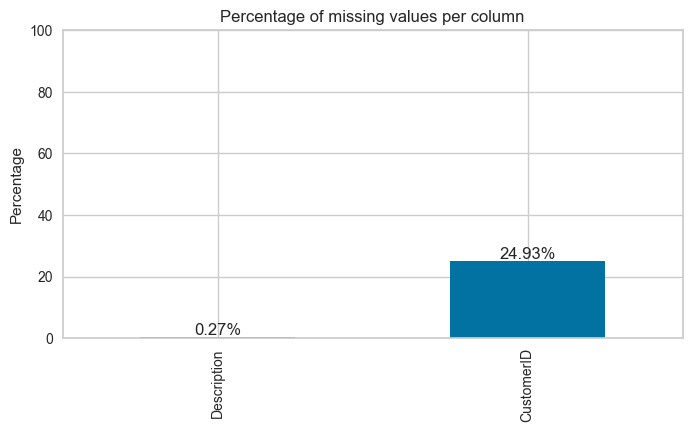

In [11]:
#VISUALIZING THE MISSING VALUES
plt.figure(figsize=(8, 4))
missing_percentage.plot(kind='bar')
plt.title('Percentage of missing values per column')
plt.ylim(0, 100)
plt.ylabel('Percentage')

for i in range(missing_percentage.shape[0]):
    plt.text(i, missing_percentage[i], f'{missing_percentage[i]:.2f}%', ha='center', va='bottom')
plt.show()

`CustomerID` (24.93% Missing Values)
The CustomerID column is pivotal for our analysis, being the key to linking purchase patterns to individual customers for clustering and personalized recommendations. With a substantial 24.93% of CustomerID values missing, the potential impact on the analysis could be significant. Imputing this large proportion of missing identifiers could introduce a high degree of bias and inaccuracies, undermining the validity of our customer segmentation and predictive modeling efforts.

Chosen Approach:

**Exclusion of Incomplete Records:** Given the importance of CustomerID in our analysis and the high proportion of missing values, we have chosen to exclude records with missing CustomerIDs. This decision prioritizes the accuracy and integrity of our customer-level analysis, ensuring that subsequent models are built on reliable and complete data.

`Description` (0.27% Missing Values)
The Description field has a relatively minor incidence of missing data. Despite the low percentage, closer inspection reveals inconsistencies in the data — the same StockCode does not consistently correspond to the same Description, indicating potential data quality issues.

Chosen Approach:

**Removal of Records with Missing Descriptions:** In light of the inconsistencies and the negligible proportion of missing Description data, we opt to remove these records. This maintains the overall quality and reliability of our dataset and ensures that our analysis is not compromised by underlying data entry errors.

In [12]:
#Removing the rows with missing values
df = df.dropna()

In [13]:
#check for misisng values
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [14]:
#HANDLING DUPLICATES
#Checking for duplicates
df.duplicated().sum()

5225

In [15]:
duplicates = df[df.duplicated()]
duplicates

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,2011-12-09 11:34:00,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,2011-12-09 11:34:00,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,2011-12-09 11:34:00,2.10,14446.0,United Kingdom


Duplicate Records Strategy

Due to the nature of our dataset, the presence of rows that are completely identical across all fields, including transaction times, is likely indicative of data entry errors rather than legitimate, repeated transactions. Such duplicates can skew our analysis by introducing noise and inaccuracies, especially when developing customer segmentation and product recommendation systems.

**Action Plan:**

To ensure the integrity of our analysis and the accuracy of our models, we will remove these duplicate rows from our dataset. This step is crucial for:

- **Enhancing Data Quality**: Ensuring that our dataset reflects unique transactions, thereby providing a more accurate view of customer behavior.
- **Improving Model Accuracy**: Cleaner data leads to more reliable clustering and predictions, essential for our goal of personalized customer engagement and effective product recommendations.

By purifying our dataset of these duplicates, we pave the way for more precise insights and actionable strategies.

In [16]:
#removing the duplicates
df = df.drop_duplicates()

In [17]:
df.shape

(401604, 8)

In [18]:
#EDA OF THE CATEGORICAL VARIABLES: InvoiceNo, StockCode, Description, Country

In [19]:
#InvoiceNo
df['InvoiceNo'].value_counts()

576339     542
579196     533
580727     529
578270     442
573576     435
          ... 
C560912      1
560913       1
560917       1
572879       1
553049       1
Name: InvoiceNo, Length: 22190, dtype: int64

In [20]:
#let's check fo the cancelled orders 
cancelled_orders = df[df['InvoiceNo'].str.contains('C', na=False)]
cancelled_orders

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [21]:
regular_transactions = df[~df['InvoiceNo'].str.contains('C', na=False)]

#calculating the percentage of cancelled orders
cancelled_percentage = (cancelled_orders.shape[0] / df.shape[0]) * 100
cancelled_percentage

2.209141343213713

In [22]:
#change the type of the InvoiceNo to string
df['InvoiceNo'] = df['InvoiceNo'].astype(str)

In [23]:
#creation of a new column to indicate the cancelled orders
df['Cancelled']= df['InvoiceNo'].apply(lambda x: 1 if 'C' in x else 0)
df['Cancelled'].value_counts()

0    392732
1      8872
Name: Cancelled, dtype: int64

In [24]:
#analysis of the rows where cancelled = 1
cancelled_orders = df[df['Cancelled'] == 1]
cancelled_orders.describe().drop('CustomerID', axis=1) #axis = 1 to drop the column

,Quantity,UnitPrice,Cancelled
count,8872.000000,8872.000000,8872.0
mean,-30.774910,18.899512,1.0
std,1172.249902,445.190864,0.0
min,-80995.000000,0.010000,1.0
25%,-6.000000,1.450000,1.0
50%,-2.000000,2.950000,1.0
75%,-1.000000,4.950000,1.0
max,-1.000000,38970.000000,1.0


**Quantity Analysis:**
- The Quantity column for cancellations has a large standard deviation, indicating a wide spread of the quantity of items involved in cancellations.
- The minimum value of -80,995 stands out as an extreme outlier, suggesting a very large bulk order was cancelled.
- The interquartile range (from the 25th percentile to the 75th percentile) suggests that most cancellations involve returning between 1 to 6 items.

**UnitPrice Analysis:**
- The standard deviation for UnitPrice is quite large, indicating significant variability in the prices of items involved in cancellations.
- The maximum UnitPrice of 38,970 is an outlier, suggesting that at least one cancellation involved an item of exceptionally high value.
- The more typical range of UnitPrice for cancelled orders (from the 25th to the 75th percentile) is between 1.45 and 4.95, which might represent the more common items involved in cancellations.

In [25]:
#StockCode
df['StockCode'].value_counts() #3684 unique stock codes

85123A    2065
22423     1894
85099B    1659
47566     1409
84879     1405
          ... 
90104        1
90135        1
90027D       1
90027A       1
84746        1
Name: StockCode, Length: 3684, dtype: int64

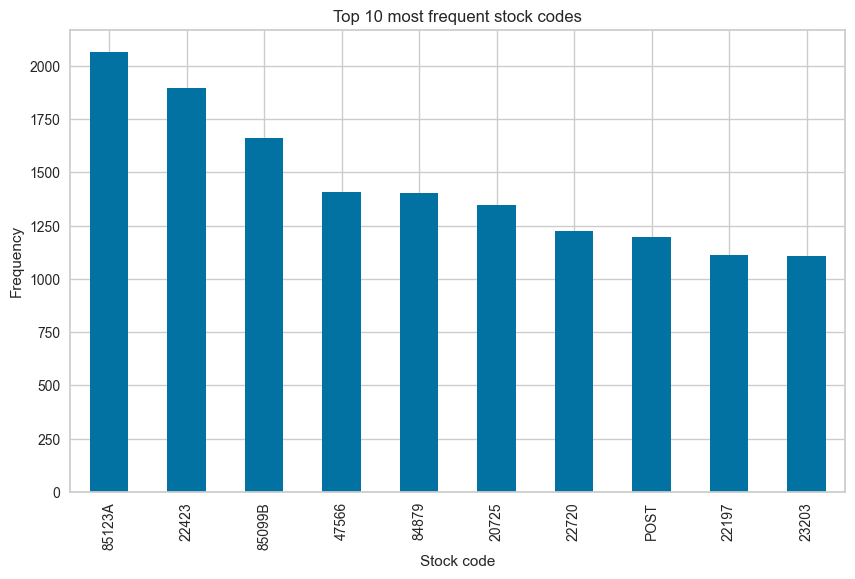

In [26]:
#plot the top 10 most frequent stock codes
plt.figure(figsize=(10, 6))
df['StockCode'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 most frequent stock codes')
plt.xlabel('Stock code')
plt.ylabel('Frequency')
plt.show()

In [27]:
#We notice that the there is a code named POST, let's ceck for other codes that are not numeric
# Finding the number of numeric characters in each unique stock code
uni_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(uni_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

#printing the values counts for unique stok codes
print(numeric_char_counts_in_unique_codes)


5    3676
0       7
1       1
dtype: int64


In [28]:
df['StockCode'] = df['StockCode'].astype(str)

# Identify non-numeric stock codes using a regular expression
non_numeric_codes = df[~df['StockCode'].str.match('^\d+$')]

# Display the unique non-numeric stock codes and their occurrences
print(non_numeric_codes['StockCode'].value_counts())

85123A    2065
85099B    1659
POST      1196
82494L     832
85099C     670
          ... 
84802B       1
84809B       1
90024C       1
90024F       1
90214Z       1
Name: StockCode, Length: 886, dtype: int64


In [29]:
anomalous_stock_codes = [code for code in uni_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]
for code in anomalous_stock_codes:
    print(code)

POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


In [30]:
#check post stock code rows
df[df['StockCode'] == 'POST'].head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.0,12583.0,France,0
386,536403,POST,POSTAGE,1,2010-12-01 11:27:00,15.0,12791.0,Netherlands,0
1123,536527,POST,POSTAGE,1,2010-12-01 13:04:00,18.0,12662.0,Germany,0
5073,536840,POST,POSTAGE,1,2010-12-02 18:27:00,18.0,12738.0,Germany,0
5258,536852,POST,POSTAGE,1,2010-12-03 09:51:00,18.0,12686.0,France,0


In [31]:
#check d stock code rows
df[df['StockCode'] == 'D'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,1
9038,C537164,D,Discount,-1,2010-12-05 13:21:00,29.29,14527.0,United Kingdom,1
14498,C537597,D,Discount,-1,2010-12-07 12:34:00,281.00,15498.0,United Kingdom,1
19392,C537857,D,Discount,-1,2010-12-08 16:00:00,267.12,17340.0,United Kingdom,1
31134,C538897,D,Discount,-1,2010-12-15 09:14:00,5.76,16422.0,United Kingdom,1


In [32]:
df[df['StockCode'] == 'C2'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
1423,536540,C2,CARRIAGE,1,2010-12-01 14:05:00,50.0,14911.0,EIRE,0
12119,537368,C2,CARRIAGE,1,2010-12-06 12:40:00,50.0,14911.0,EIRE,0
12452,537378,C2,CARRIAGE,1,2010-12-06 13:06:00,50.0,14911.0,EIRE,0
19975,537963,C2,CARRIAGE,1,2010-12-09 11:30:00,50.0,13369.0,United Kingdom,0
20016,538002,C2,CARRIAGE,1,2010-12-09 11:48:00,50.0,14932.0,Channel Islands,0


In [33]:
# Calculating the percentage of records with these stock codes
percentage_anomalous = (df['StockCode'].isin(anomalous_stock_codes).sum() / len(df)) * 100
percentage_anomalous

0.4768378801007958

Upon reviewing the dataset, we've identified special stock codes like 'POST' for postage costs, 'D' for discounts, and 'C2' for carriage charges. These entries, while important for full transactional records, do not represent physical product sales. They account for only 0.48% of the total transactions.

Rationale for Exclusion:

- Product-Centric Analysis: Our primary focus is on analyzing product sales data. Including service fees and discounts would not contribute to insights on product trends or customer purchasing behavior.
- Noise Reduction: Excluding these codes prevents the distortion of product-centric metrics and models, ensuring a more accurate representation of inventory and sales performance.
- Clarity in Financials: While crucial for financial reporting, these service-related codes are peripheral to analyses aimed at understanding product popularity or stock management.

Given their negligible proportion and potential to introduce noise into product-focused analyses, we have decided to remove these entries from the product transaction dataset. This strategic exclusion enhances the accuracy and relevance of our findings, concentrating our efforts on genuine product transactions.

In [34]:
#Removing the rows with the anomalous stock codes
df = df[~df['StockCode'].isin(anomalous_stock_codes)]
df = pd.DataFrame(filter(lambda x: x['StockCode'] not in anomalous_stock_codes, df.to_dict('records')))
df.shape

(399689, 9)

In [35]:
#Description
description_values = df['Description'].value_counts()
description_values

WHITE HANGING HEART T-LIGHT HOLDER    2058
REGENCY CAKESTAND 3 TIER              1894
JUMBO BAG RED RETROSPOT               1659
PARTY BUNTING                         1409
ASSORTED COLOUR BIRD ORNAMENT         1405
                                      ... 
FRYING PAN RED POLKADOT                  1
PEG BAG APPLE DESIGN                     1
PINK POLKADOT KIDS BAG                   1
BLACK DIAMOND CLUSTER NECKLACE           1
SET 12 COLOURING PENCILS DOILEY          1
Name: Description, Length: 3888, dtype: int64

<Axes: >

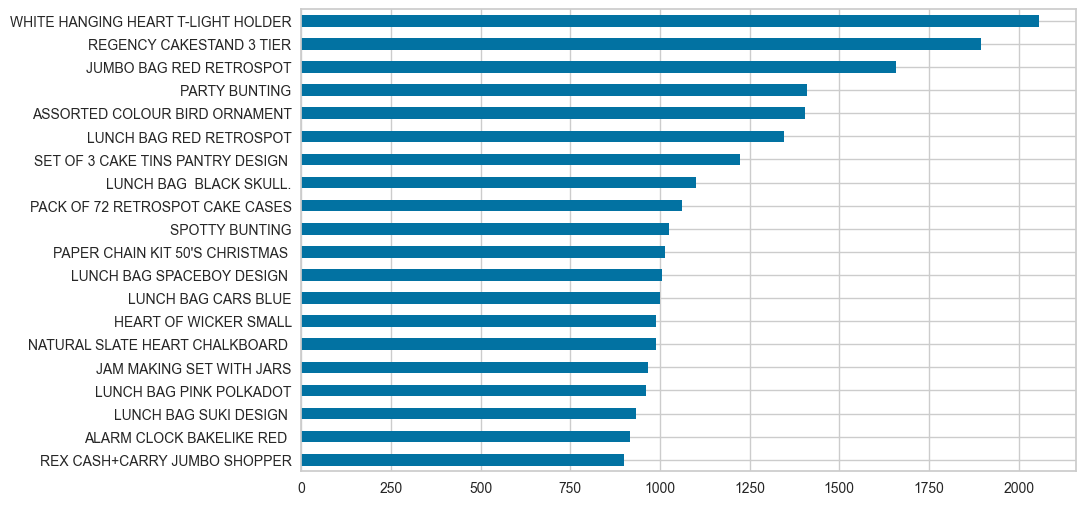

In [36]:
#plot the top 15 most frequent descriptions orizontal bar plot ordered by frequency
plt.figure(figsize=(10,6))
description_values.head(20).sort_values(ascending=True).plot(kind='barh')

In [37]:
#check if all the descriptions are in upper case
df['Description'].str.isupper().all()

False

In [38]:
#get the non upper case descriptions
non_upper_case_descriptions = df[~df['Description'].str.isupper()]
non_upper_case_descriptions['Description'].value_counts()

BAG 125g SWIRLY MARBLES                252
3 TRADITIONAl BISCUIT CUTTERS  SET     207
BAG 250g SWIRLY MARBLES                201
POLYESTER FILLER PAD 40x40cm           185
POLYESTER FILLER PAD 45x45cm           135
BAG 500g SWIRLY MARBLES                115
Next Day Carriage                       80
FRENCH BLUE METAL DOOR SIGN No          75
POLYESTER FILLER PAD 45x30cm            37
POLYESTER FILLER PAD 30CMx30CM          26
ESSENTIAL BALM 3.5g TIN IN ENVELOPE     18
NUMBER TILE COTTAGE GARDEN No           12
FOLK ART GREETING CARD,pack/12          10
NUMBER TILE VINTAGE FONT No              7
THE KING GIFT BAG 25x24x12cm             7
POLYESTER FILLER PAD 65CMx65CM           5
FLOWERS HANDBAG blue and orange          3
High Resolution Image                    3
POLYESTER FILLER PAD 60x40cm             1
Name: Description, dtype: int64

In [39]:
non_upper_case_descriptions[non_upper_case_descriptions['Description']== 'Next Day Carriage']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
144018,554835,23444,Next Day Carriage,1,2011-05-26 16:11:00,15.0,15241.0,United Kingdom,0
147145,555251,23444,Next Day Carriage,1,2011-06-01 15:12:00,15.0,13062.0,United Kingdom,0
147534,555312,23444,Next Day Carriage,1,2011-06-02 10:39:00,15.0,16484.0,United Kingdom,0
147881,555367,23444,Next Day Carriage,1,2011-06-02 14:28:00,15.0,17900.0,United Kingdom,0
153445,555948,23444,Next Day Carriage,1,2011-06-08 10:49:00,30.0,13752.0,United Kingdom,0
...,...,...,...,...,...,...,...,...,...
389101,580622,23444,Next Day Carriage,1,2011-12-05 12:09:00,15.0,17006.0,United Kingdom,0
389114,580630,23444,Next Day Carriage,1,2011-12-05 12:11:00,15.0,12913.0,United Kingdom,0
395331,581132,23444,Next Day Carriage,1,2011-12-07 12:55:00,15.0,17590.0,United Kingdom,0
396617,581221,23444,Next Day Carriage,1,2011-12-08 09:40:00,15.0,17856.0,United Kingdom,0


In [40]:
non_upper_case_descriptions[non_upper_case_descriptions['Description']== 'High Resolution Image']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
297478,571739,23702,High Resolution Image,1,2011-10-19 10:33:00,3.0,12500.0,Germany,0
341145,575910,23702,High Resolution Image,2,2011-11-11 16:05:00,1.5,14836.0,United Kingdom,0
349663,576659,23702,High Resolution Image,1,2011-11-16 11:09:00,21.0,15373.0,United Kingdom,0


In [41]:
#let's calculate the percentage of non upper case descriptions
(non_upper_case_descriptions.shape[0]/df.shape[0])*100

0.34501825169068956

An inspection of the product descriptions has revealed the presence of lowercase entries which appear to be anomalies within our dataset. Notably, descriptions such as 'Next Day Carriage' and 'High Resolution Image' do not align with the standard product offerings of FarTrend and are likely to represent service fees or digital goods.

Proposed Strategy:
- Service charges like 'Next Day Carriage' and operational items such as 'High Resolution Image' do not correlate with physical products and therefore will be excluded. This ensures that our analysis focuses solely on tangible goods, which are the primary interest for our customer segmentation and recommendation system.

- Normalize the remaining product descriptions to uppercase. This standardization avoids the complication of case-sensitive duplicity and fosters uniformity, facilitating more accurate data analysis and model performance.

The execution of this strategy will refine our dataset, rendering it more amenable to the sophisticated analytical techniques we plan to employ. The end result will be a more precise and dependable basis for our machine learning endeavors, directly supporting the strategic goals of personalized marketing and improved customer experience at FarTrend


In [42]:
#removing the 'Next Day Carriage' and 'High Resolution Image' rows
df = df[df['Description'] != 'Next Day Carriage']
df = df[df['Description']!= 'High Resolution Image']

#transforming th other rows in upper case
df['Description'] = df['Description'].str.upper()
df.shape

(399606, 9)

In [43]:
#EDA OF THE NUMERICAL VARIABLES: UnitPrice, Quantity

In [44]:
df['UnitPrice'].describe()

count    399606.000000
mean          2.904957
std           4.448796
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

The descriptive statistics for UnitPrice suggest that the average price of products is relatively low at around 2.90 units of currency, with half of the products priced at or below 1.95. However, there is notable variability in product prices, as indicated by a standard deviation of approximately 4.45, and a range that extends to a maximum of 649.50, which implies the presence of high-priced items in the catalogue that could significantly skew the average.


The presence of a minimum unit price of 0.00 warrants further investigation, as this could indicate instances of giveaways, data entry errors, or special promotions that effectively reduce the price to nothing. Understanding the nature of these zero-priced transactions is crucial, as they may need to be treated separately in the analysis to avoid distorting the overall pricing trends and the predictive modeling of customer behavior.


In [45]:
#Let's check the description for the rows with the minimum unit price
df[df['UnitPrice']== 0].describe() [['Quantity', 'Cancelled']]

,Quantity,Cancelled
count,33.000000,33.0
mean,420.515152,0.0
std,2176.713608,0.0
min,1.000000,0.0
25%,2.000000,0.0
50%,11.000000,0.0
75%,36.000000,0.0
max,12540.000000,0.0


The transactions with a UnitPrice of 0 represent a very small subset of the data, and their exclusion is unlikely to significantly impact the dataset given the count of 33. The high standard deviation in Quantity suggests a wide variance in the volume of items involved in these zero-priced transactions. Since none of these transactions are marked as cancelled, they are not corrections or cancellations but actual transactions where goods were exchanged without monetary cost. Removing these entries will help to maintain the integrity of the dataset and the reliability of any statistical or machine learning models, which would assume a positive cost of goods sold in a standard e-commerce environment.

In [46]:
#removing the rows with the unit price = 0
df = df[df['UnitPrice'] > 0]
df.shape

(399573, 9)

In [47]:
#reset the index
df = df.reset_index(drop=True)

In [48]:
#categorical variables
df.describe(include='object')

,InvoiceNo,StockCode,Description,Country
count,399573,399573,399573,399573
unique,21781,3674,3886,37
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,541,2065,2058,356008


The recent analysis shows that the number of unique stock codes and descriptions now closely aligns, reflecting significant progress in our data cleaning efforts. This crucial step ensures each product is accurately represented, setting the stage for more dependable analysis and modeling in our project.

OUTLIERS TREARTMENT

In our K-means clustering approach, we must be mindful of the impact of outliers, which are particularly influential in the positioning of centroids, potentially distorting the resulting clusters. Our preliminary analysis indicates a substantial portion of these outliers corresponds to cancellation orders. This is evident in the 'Quantity' data, where cancellations show a high variance, with extremes such as a cancelled bulk order of -80,995 items. Similarly, the 'UnitPrice' data reveals significant fluctuations, including an exceptional cancellation involving an item valued at 38,970.

Given the goal of understanding customer behavior through K-means clustering, addressing these outliers will be more effective after we transition from transactional data to a customer-centric view during feature engineering. This would allow us to evaluate the true behavioral patterns without prematurely discarding data that might be significant for segmenting customers—especially since cancellations, while outliers in transactional terms, could offer valuable insights into customer satisfaction and preferences. Thus, the treatment of outliers, particularly those linked with cancellations, will be deferred until we analyze the customer-based dataset, ensuring a robust foundation for our clustering strategy.

#### FEATURE ENGINEERING
- Total Spend per Transaction: Multiplying Quantity by UnitPrice to calculate the total spend for each line item, and then summing this up per invoice could provide insights into customer spending habits.
- Purchase Frequency: Counting the number of invoices per customer to understand how often they purchase.
- Average Spend per Visit: Calculating the average spend per invoice for each customer could help identify high-value customers.
- Product Variety per Transaction: Counting the number of unique StockCode or Description items per invoice to gauge the diversity of products a customer is interested in.
- Time Since Last Purchase: For each customer, calculating the time elapsed since their last purchase could help in identifying churn risk.
- Day of the Week and Hour of Purchase: Extracting day of the week and hour from InvoiceDate to understand peak shopping times and tailor marketing strategies accordingly.
- Cancellation Rate: Calculating the proportion of transactions that are cancellations (Cancelled == 1) for each customer to assess satisfaction or operational issues.
- Geographical Insights: Aggregating sales data by Country to identify key markets and tailor regional strategies.
- Seasonality Trends: Analyzing InvoiceDate to identify trends in purchasing behavior across different times of the year.

These features can provide a comprehensive view of customer engagement, preferences, and purchasing patterns, enabling targeted marketing efforts and improved customer segmentation. 

In [49]:
#1 - Tot spending per customer
df['TotalSpend'] = df['Quantity'] * df['UnitPrice']

#grouping by customer id
total_spending_per_customer = df.groupby('CustomerID')['TotalSpend'].sum().reset_index().rename(columns={'TotalSpend': 'TotalCustomerSpend'})
total_spending_per_customer.head()

customer_df = pd.DataFrame(df['CustomerID'].unique(), columns=['CustomerID'])

# Merge the TotalCustomerSpend into customer_df
customer_df = customer_df.merge(total_spending_per_customer, on='CustomerID', how='left')

customer_df.head()

,CustomerID,TotalCustomerSpend
0,17850.0,5303.48
1,13047.0,3089.10
2,12583.0,6629.34
3,13748.0,948.25
4,15100.0,635.10


The TotalCustomerSpend feature captures the cumulative amount each customer has spent, offering a direct measure of customer value. This aggregate view enables us to identify high-value customers for targeted marketing initiatives, optimize loyalty programs, and tailor our product offerings to encourage increased spending. Understanding total spend is foundational for effective customer segmentation and personalization strategies.

In [ ]:
#2 - Purchase frequency
purchase_frequency = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index().rename(columns={'InvoiceNo': 'PurchaseFrequency'})

#Update customer_df with Purchase Frequency
customer_df = customer_df.merge(purchase_frequency, on='CustomerID', how='left')

customer_df.head()

,CustomerID,TotalCustomerSpend,PurchaseFrequency
0,17850.0,5303.48,35
1,13047.0,3089.10,16
2,12583.0,6629.34,17
3,13748.0,948.25,5
4,15100.0,635.10,6


Purchase frequency sheds light on customer engagement levels, helping to distinguish between one-time buyers and regular shoppers. By segmenting customers based on how frequently they purchase, businesses can tailor their marketing strategies to target each segment effectively, enhancing customer retention and encouraging more frequent purchases.

In [ ]:
#3 - Average spending per purchase
customer_df.shape
#Calculate Average Spend per Visit
customer_df['AverageSpendPerVisit'] = customer_df['TotalCustomerSpend'] / customer_df['PurchaseFrequency']

customer_df.head()


,CustomerID,TotalCustomerSpend,PurchaseFrequency,AverageSpendPerVisit
0,17850.0,5303.48,35,151.528000
1,13047.0,3089.10,16,193.068750
2,12583.0,6629.34,17,389.961176
3,13748.0,948.25,5,189.650000
4,15100.0,635.10,6,105.850000


The AverageSpendPerVisit feature calculates the average amount spent by customers per transaction, highlighting their spending power and preference. This insight is crucial for distinguishing between high-value and low-value customers, enabling targeted marketing campaigns, personalized offers, and loyalty programs aimed at boosting customer lifetime value and enhancing overall profitability.

In [ ]:
#4 - Average product variety
# Calculate the number of unique products purchased per invoice
product_variety = df.groupby('InvoiceNo')['StockCode'].nunique().reset_index().rename(columns={'StockCode': 'ProductVariety'})

# Merge the product variety DataFrame with the original df
df = df.merge(product_variety, on='InvoiceNo', how='left')

avg_product_variety_customer = df.groupby('CustomerID')['ProductVariety'].mean().reset_index()
avg_product_variety_customer.rename(columns={'ProductVariety': 'AvgProductVariety'})

#update customer_df with AvgProductVariety
customer_df = customer_df.merge(avg_product_variety_customer, on='CustomerID', how='left')
customer_df.head()

,CustomerID,TotalCustomerSpend,PurchaseFrequency,AverageSpendPerVisit,ProductVariety
0,17850.0,5303.48,35,151.528000,14.203883
1,13047.0,3089.10,16,193.068750,22.742268
2,12583.0,6629.34,17,389.961176,16.787234
3,13748.0,948.25,5,189.650000,9.071429
4,15100.0,635.10,6,105.850000,1.000000


Understanding the average product variety per transaction at the customer level offers insights into their purchasing behavior, indicating whether they prefer to explore a wide range of products or stick to a specific category with each purchase. This feature can significantly enhance customer segmentation by identifying niche markets, optimizing product recommendations, and tailoring marketing campaigns to match customer interests, ultimately driving increased sales and customer satisfaction.

In [ ]:
#5 - Time since last purchase
# Convert InvoiceDate to datetime

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate the most recent purchase date
most_recent_purchase = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
most_recent_purchase.rename(columns={'InvoiceDate': 'MostRecentPurchase'}, inplace=True)

# Calculate the time since the most recent purchase
reference_date = most_recent_purchase['MostRecentPurchase'].max() + pd.Timedelta(days=1)
most_recent_purchase['TimeSinceLastPurchase'] = (reference_date - most_recent_purchase['MostRecentPurchase']).dt.days

# Update customer_df with Time Since Last Purchase
customer_df = customer_df.merge(most_recent_purchase[['CustomerID', 'TimeSinceLastPurchase']], on='CustomerID', how='left')
customer_df.head()

,CustomerID,TotalCustomerSpend,PurchaseFrequency,AverageSpendPerVisit,ProductVariety,TimeSinceLastPurchase
0,17850.0,5303.48,35,151.528000,14.203883,302
1,13047.0,3089.10,16,193.068750,22.742268,46
2,12583.0,6629.34,17,389.961176,16.787234,3
3,13748.0,948.25,5,189.650000,9.071429,96
4,15100.0,635.10,6,105.850000,1.000000,330


The TimeSinceLastPurchase feature is a powerful indicator of customer engagement, helping to identify customers who may be drifting away or at risk of churning. By targeting these customers with re-engagement campaigns, personalized offers, or feedback requests, businesses can potentially reactivate them and strengthen customer loyalty. This metric is also essential for segmentation, allowing for tailored strategies based on how recently customers have interacted with the brand.

In [ ]:
# 6 - Day of the week and 7 hour of purchase

# Extract Day of the Week and Hour of Purchase
df['PurchaseDay'] = df['InvoiceDate'].dt.dayofweek + 1 # Monday is 1, Sunday is 7
df['PurchaseHour'] = df['InvoiceDate'].dt.hour

# Aggregate these to get the most common purchase day and hour for each customer
most_common_purchase_day = df.groupby('CustomerID')['PurchaseDay'].agg(lambda x: x.mode()[0]).reset_index().rename(columns={'PurchaseDay': 'MostCommonPurchaseDay'})
most_common_purchase_hour = df.groupby('CustomerID')['PurchaseHour'].agg(lambda x: x.mode()[0]).reset_index().rename(columns={'PurchaseHour': 'MostCommonPurchaseHour'})

# Update customer_df with these new features
customer_df = customer_df.merge(most_common_purchase_day, on='CustomerID', how='left')
customer_df = customer_df.merge(most_common_purchase_hour, on='CustomerID', how='left')

customer_df.head()

,CustomerID,TotalCustomerSpend,PurchaseFrequency,AverageSpendPerVisit,ProductVariety,TimeSinceLastPurchase,MostCommonPurchaseDay,MostCommonPurchaseHour
0,17850.0,5303.48,35,151.528000,14.203883,302,4,9
1,13047.0,3089.10,16,193.068750,22.742268,46,3,13
2,12583.0,6629.34,17,389.961176,16.787234,3,5,12
3,13748.0,948.25,5,189.650000,9.071429,96,1,9
4,15100.0,635.10,6,105.850000,1.000000,330,3,9


The MostCommonPurchaseDay and MostCommonPurchaseHour features unlock deep insights into customer purchasing patterns, highlighting preferred shopping times and enabling targeted marketing strategies. By understanding peak activity periods, businesses can optimize engagement efforts, aligning promotions and communications with when customers are most likely to shop. This precision not only enhances customer experience but also drives sales efficiency, ensuring resources are focused during key buying times.

In [ ]:
#8 - Number of cancellations and cancellation rate
#Count the Number of Cancellations per Customer
cancellations_per_customer = df[df['Cancelled'] == 1].groupby('CustomerID').size().reset_index(name='NumCancellations')

# 9 Count the Total Number of Transactions per Customer
total_transactions_per_customer = df.groupby('CustomerID').size().reset_index(name='TotalTransactions')

#Merge these counts back to customer_df
customer_df = customer_df.merge(cancellations_per_customer, on='CustomerID', how='left').fillna(0)
customer_df = customer_df.merge(total_transactions_per_customer, on='CustomerID', how='left')

# 10 Determine the Cancellation Rate
customer_df['CancellationRate'] = customer_df['NumCancellations'] / customer_df['TotalTransactions']

customer_df.head()

,CustomerID,TotalCustomerSpend,PurchaseFrequency,AverageSpendPerVisit,ProductVariety,TimeSinceLastPurchase,MostCommonPurchaseDay,MostCommonPurchaseHour,NumCancellations,TotalTransactions,CancellationRate
0,17850.0,5303.48,35,151.528000,14.203883,302,4,9,12.0,309,0.038835
1,13047.0,3089.10,16,193.068750,22.742268,46,3,13,23.0,194,0.118557
2,12583.0,6629.34,17,389.961176,16.787234,3,5,12,3.0,235,0.012766
3,13748.0,948.25,5,189.650000,9.071429,96,1,9,0.0,28,0.000000
4,15100.0,635.10,6,105.850000,1.000000,330,3,9,3.0,6,0.500000


The CancellationRate feature provides a quantifiable measure of customer satisfaction and the efficiency of operational processes. A high cancellation rate may indicate dissatisfaction with the product or service, issues with the ordering or delivery process, or possibly a higher frequency of impulse buys followed by remorse from the customer. By identifying customers or segments with higher cancellation rates, FarTrend can investigate underlying causes and take steps to improve customer experience, streamline operations, and reduce the rate of order cancellations. This metric can also be used to fine-tune predictive models to better forecast demand and manage inventory.

In [ ]:
df['Country'].value_counts(normalize=True).head()

United Kingdom    0.890971
Germany           0.022722
France            0.020402
EIRE              0.018440
Spain             0.006162
Name: Country, dtype: float64

In [ ]:
#11 - Customer country
# Group by CustomerID and Country to get the number of transactions per country for each customer
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

# Get the country with the maximum number of transactions for each customer (in case a customer has transactions from multiple countries)
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

# Create a binary column indicating whether the customer is from the UK or not
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

# Merge this data with our customer_data dataframe
customer_df = pd.merge(customer_df, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')

# Display the first few rows of the customer_data dataframe
customer_df.head()

,CustomerID,TotalCustomerSpend,PurchaseFrequency,AverageSpendPerVisit,ProductVariety,TimeSinceLastPurchase,MostCommonPurchaseDay,MostCommonPurchaseHour,NumCancellations,TotalTransactions,CancellationRate,Is_UK
0,17850.0,5303.48,35,151.528000,14.203883,302,4,9,12.0,309,0.038835,1
1,13047.0,3089.10,16,193.068750,22.742268,46,3,13,23.0,194,0.118557,1
2,12583.0,6629.34,17,389.961176,16.787234,3,5,12,3.0,235,0.012766,0
3,13748.0,948.25,5,189.650000,9.071429,96,1,9,0.0,28,0.000000,1
4,15100.0,635.10,6,105.850000,1.000000,330,3,9,3.0,6,0.500000,1


The prominence of the UK in the dataset, reflected through its significant impact percentage, underscores the necessity of the binary indicator feature for geographical analysis. This binary distinction enhances our capacity to tailor strategies by clearly delineating between the UK and other markets, allowing for targeted insights and decision-making in a market that dominates the dataset.

In [ ]:
#12 - Total quantity of products purchased
# Calculate the total quantity of products purchased by each customer
total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index(name='Total_Products_Purchased')

# Merge this feature back into the customer_df
customer_df = customer_df.merge(total_products_purchased, on='CustomerID', how='left')

customer_df.head()

,CustomerID,TotalCustomerSpend,PurchaseFrequency,AverageSpendPerVisit,ProductVariety,TimeSinceLastPurchase,MostCommonPurchaseDay,MostCommonPurchaseHour,NumCancellations,TotalTransactions,CancellationRate,Is_UK,Total_Products_Purchased
0,17850.0,5303.48,35,151.528000,14.203883,302,4,9,12.0,309,0.038835,1,1696
1,13047.0,3089.10,16,193.068750,22.742268,46,3,13,23.0,194,0.118557,1,1355
2,12583.0,6629.34,17,389.961176,16.787234,3,5,12,3.0,235,0.012766,0,4978
3,13748.0,948.25,5,189.650000,9.071429,96,1,9,0.0,28,0.000000,1,439
4,15100.0,635.10,6,105.850000,1.000000,330,3,9,3.0,6,0.500000,1,58


Average Days Between Purchases: This feature represents the average number of days a customer waits before making another purchase. Understanding this can help in predicting when the customer is likely to make their next purchase, which can be a crucial metric for targeted marketing and personalized promotions.

In [ ]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4362 entries, 0 to 4361
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CustomerID                4362 non-null   float64
 1   TotalCustomerSpend        4362 non-null   float64
 2   PurchaseFrequency         4362 non-null   int64  
 3   AverageSpendPerVisit      4362 non-null   float64
 4   ProductVariety            4362 non-null   float64
 5   TimeSinceLastPurchase     4362 non-null   int64  
 6   MostCommonPurchaseDay     4362 non-null   int64  
 7   MostCommonPurchaseHour    4362 non-null   int64  
 8   NumCancellations          4362 non-null   float64
 9   TotalTransactions         4362 non-null   int64  
 10  CancellationRate          4362 non-null   float64
 11  Is_UK                     4362 non-null   int64  
 12  Total_Products_Purchased  4362 non-null   int64  
dtypes: float64(6), int64(7)
memory usage: 477.1 KB


Having carefully prepared our dataset, we're ready to move on to the next steps of our project. This includes closely examining our data to spot any patterns or trends, ensuring our data is as clean and reliable as possible by identifying and dealing with any outliers, and getting our data ready for clustering. These steps are crucial for building a solid foundation for creating customer segments and eventually developing a tailored recommendation system. Our immediate next task is to focus on detecting and managing outliers, ensuring our analysis remains robust and our insights are dependable.

In [ ]:
#OUTLIERS
#Isolation forest
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=42)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_df['Outlier_Scores'] = model.fit_predict(customer_df.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (0 for inliers and 1 for outliers)
customer_df['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_df['Outlier_Scores']]

# Display the first few rows of the customer_data dataframe
customer_df.head()

,CustomerID,TotalCustomerSpend,PurchaseFrequency,AverageSpendPerVisit,ProductVariety,TimeSinceLastPurchase,MostCommonPurchaseDay,MostCommonPurchaseHour,NumCancellations,TotalTransactions,CancellationRate,Is_UK,Total_Products_Purchased,Outlier_Scores,Is_Outlier
0,17850.0,5303.48,35,151.528000,14.203883,302,4,9,12.0,309,0.038835,1,1696,-1,1
1,13047.0,3089.10,16,193.068750,22.742268,46,3,13,23.0,194,0.118557,1,1355,1,0
2,12583.0,6629.34,17,389.961176,16.787234,3,5,12,3.0,235,0.012766,0,4978,-1,1
3,13748.0,948.25,5,189.650000,9.071429,96,1,9,0.0,28,0.000000,1,439,1,0
4,15100.0,635.10,6,105.850000,1.000000,330,3,9,3.0,6,0.500000,1,58,-1,1


In [ ]:
#OUTLIERS
#Isolation forest
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=42)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_df['Outlier_Scores'] = model.fit_predict(customer_df.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (0 for inliers and 1 for outliers)
customer_df['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_df['Outlier_Scores']]

# Display the first few rows of the customer_data dataframe
customer_df.head()

,CustomerID,TotalCustomerSpend,PurchaseFrequency,AverageSpendPerVisit,ProductVariety,TimeSinceLastPurchase,MostCommonPurchaseDay,MostCommonPurchaseHour,NumCancellations,TotalTransactions,CancellationRate,Is_UK,Total_Products_Purchased,Outlier_Scores,Is_Outlier
0,17850.0,5303.48,35,151.528000,14.203883,302,4,9,12.0,309,0.038835,1,1696,-1,1
1,13047.0,3089.10,16,193.068750,22.742268,46,3,13,23.0,194,0.118557,1,1355,1,0
2,12583.0,6629.34,17,389.961176,16.787234,3,5,12,3.0,235,0.012766,0,4978,-1,1
3,13748.0,948.25,5,189.650000,9.071429,96,1,9,0.0,28,0.000000,1,439,1,0
4,15100.0,635.10,6,105.850000,1.000000,330,3,9,3.0,6,0.500000,1,58,-1,1


Isolation Forest's ability to manage the intricacies of high-dimensional data while being less susceptible to the skewing effects of outliers makes it a strong candidate for our initial outlier detection efforts. After identifying outliers, a thorough examination to understand their nature and impact on our dataset is crucial. Depending on this analysis, we may choose to remove, adjust, or further investigate these outliers to ensure that out customer segmentation is as accurate and insightful as possible.

In [ ]:
#calculate the percentage of outliers
outlier_percentage = (customer_df['Is_Outlier'].sum() / customer_df.shape[0]) * 100
outlier_percentage

5.020632737276479

Looking at the results, we see that around 5% of our customers are marked as outliers. This number is just right—it's not so high that we're losing too much data, but it's high enough to make sure we're getting rid of data that could mess up our analysis. It looks like our use of the Isolation Forest algorithm to spot outliers has done a good job, making sure our customer segmentation is on the right track

In [ ]:
#separate the outliers from the dataset 
outliers = customer_df[customer_df['Is_Outlier'] == 1]

#remove the outliers from the dataset
customer_df = customer_df[customer_df['Is_Outlier'] == 0]

#drop the columns that we used to detect the outliers
customer_df = customer_df.drop(['Outlier_Scores', 'Is_Outlier'], axis=1)

customer_df.head()


,CustomerID,TotalCustomerSpend,PurchaseFrequency,AverageSpendPerVisit,ProductVariety,TimeSinceLastPurchase,MostCommonPurchaseDay,MostCommonPurchaseHour,NumCancellations,TotalTransactions,CancellationRate,Is_UK,Total_Products_Purchased
1,13047.0,3089.10,16,193.068750,22.742268,46,3,13,23.0,194,0.118557,1,1355
3,13748.0,948.25,5,189.650000,9.071429,96,1,9,0.0,28,0.000000,1,439
5,15291.0,4551.51,19,239.553158,11.462963,26,3,16,6.0,108,0.055556,1,2073
6,14688.0,5055.61,27,187.244815,20.539326,8,2,12,32.0,356,0.089888,1,3185
7,17809.0,5344.85,14,381.775000,11.412698,16,5,15,2.0,63,0.031746,1,2016


In [ ]:
customer_df.shape[0]

4143

After identifying outliers using the Isolation Forest algorithm, we've decided to eliminate these data points from our main dataset. This decision is based on the understanding that outliers can significantly skew the results of our analysis, especially in customer segmentation where the goal is to identify homogeneous groups of customers. By removing outliers, we ensure that our segmentation process is not influenced by extreme values that do not represent typical customer behavior. This step enhances the accuracy and relevancy of our segmentation model, leading to more actionable insights. The subsequent removal of the 'Outlier_Scores' and 'Is_Outlier' columns streamlines our dataset, focusing on the core attributes necessary for our analysis moving forward.

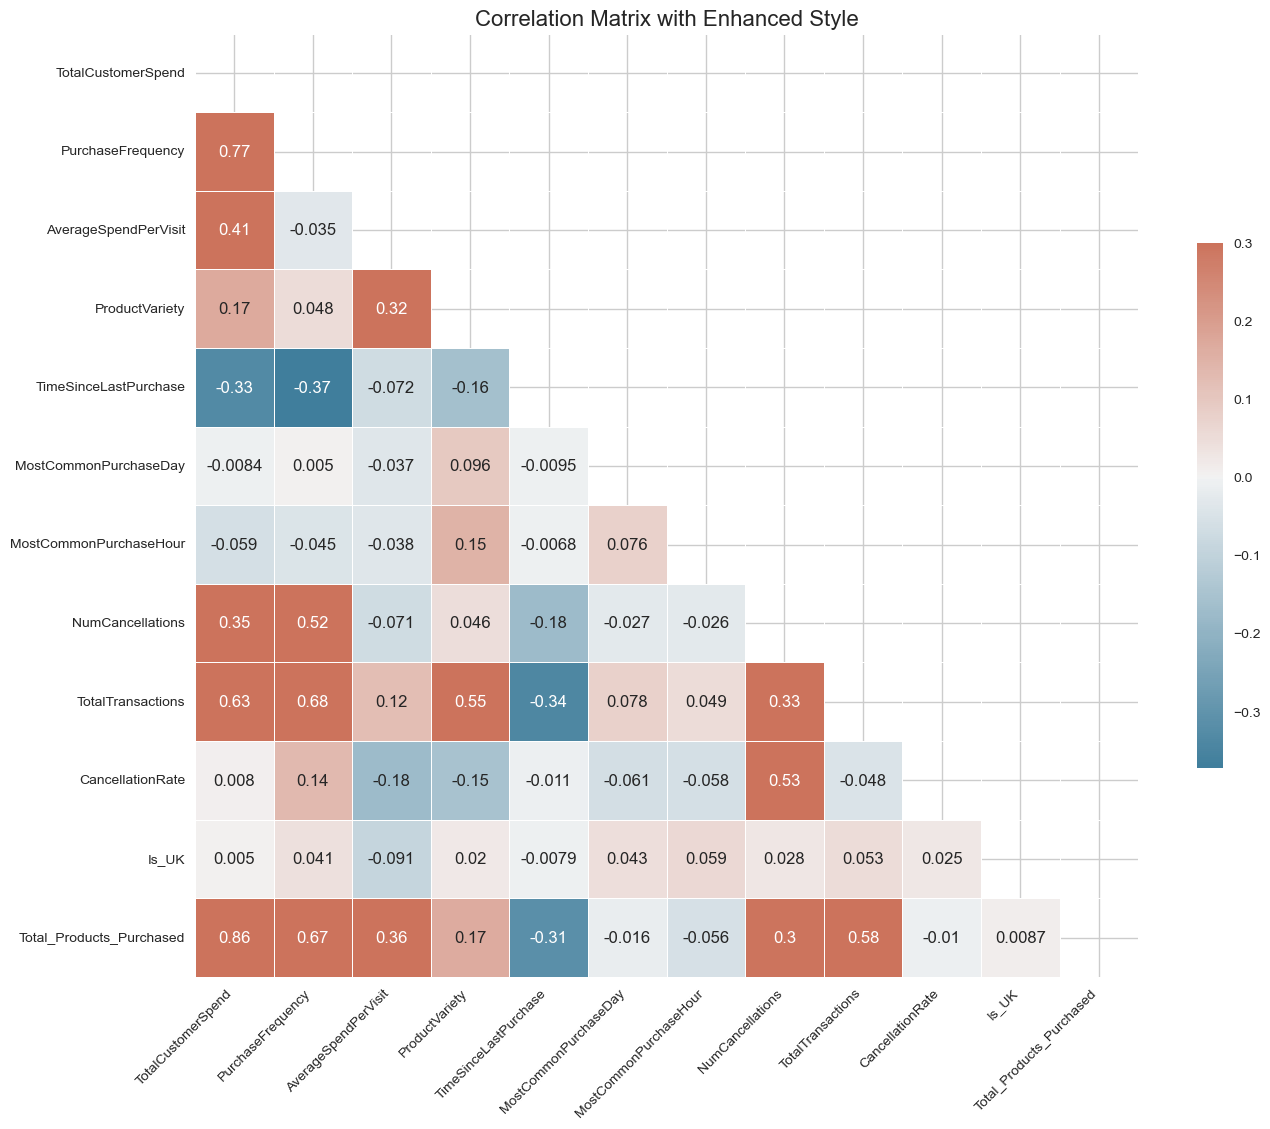

In [ ]:
#CORRELATION ANALYSIS
#correlation matrix escape the customer id
corr_matrix = customer_df.iloc[:, 1:].corr()

## Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(14, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

# Adjust the layout to make it more readable
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Matrix with Enhanced Style', fontsize=16)
plt.tight_layout()  # Adjust layout to fit

# Show the heatmap
plt.show()

The correlation matrix plot reveals significant multicollinearity among certain features, which can impact the performance and interpretability of a K-means clustering model. To address this and enhance the robustness of our customer segmentation, we will implement Principal Component Analysis (PCA). PCA will help us to reduce dimensionality, distill our features into principal components that capture the most variance, and reduce the redundancy in our dataset, thereby providing a more solid foundation for the clustering algorithm.

#### P1.2 Description of the main data insights.

Leveraging the comprehensive exploratory data analysis (EDA) and subsequent feature engineering process, several pivotal insights emerge that have direct implications for FarTrend’s strategic marketing and customer engagement initiatives.

The detailed EDA process illuminated the complexity of FarTrend's customer behaviors and transaction patterns. A critical finding from the analysis was the identification of outliers and the segmentation of customers based on metrics such as total spend, purchasing frequency, and cancellation rates. These insights reveal a diverse customer base, from high-value, frequent shoppers to those with minimal engagement or high cancellation rates. For FarTrend, this segmentation is a goldmine for personalizing marketing efforts. High-value customers, characterized by their consistent spending and loyalty, are prime candidates for exclusive offers and premium membership programs, aimed at enhancing retention and increasing lifetime value. Meanwhile, strategies to re-engage low-engagement customers or those with high cancellation rates could involve targeted discounts, feedback solicitation to understand their dissatisfaction, and personalized product recommendations to reignite their interest.

Furthermore, the feature engineering phase, which produced variables like average spend per visit, product variety per transaction, and geographical insights, equips FarTrend with the tools to delve deeper into customer preferences and buying habits. The introduction of geographical insights, for instance, not only highlights the significant concentration of customers in the UK but also opens avenues for regional marketing strategies that cater to specific tastes and preferences, potentially unlocking new markets or consolidating existing ones. Similarly, understanding the product variety in customers' purchases offers FarTrend an opportunity to cross-sell and up-sell, driving sales by recommending complementary products or highlighting items of interest based on past buying behavior. These tailored strategies, informed by robust data analysis, promise to elevate customer satisfaction, foster loyalty, and ultimately, drive FarTrend’s growth in the competitive e-commerce landscape. In summary, the insights drawn from the EDA and feature engineering not only spotlight the multifaceted nature of customer interactions with FarTrend but also offer a strategic blueprint for enhancing personalized customer experiences and optimizing marketing efforts for diverse customer segments.

## Part 2: Segment the clients based on their purchase profile

#### P2.1 Build a baseline model to segment the costumers.

Feature scaling is crucial before applying PCA (and many machine learning algorithms) because it standardizes the data to have a mean of zero and a variance of one. This is important because PCA is sensitive to the scale of the features. If the features are on different scales (e.g., one feature ranges from 1 to 10 and another from 1 to 1000), the PCA could be biased towards the feature with a larger scale, incorrectly interpreting it as having more importance.

In [ ]:
#FEATURE SCALING
#Initialize the StandardScaler
scaler = StandardScaler()

#Fit and transform the data
not_scaling_col = ['CustomerID', 'Is_UK', 'MostCommonPurchaseDay']

#List of columns to scale
cols_to_scale = [col for col in customer_df.columns if col not in not_scaling_col]

#Fit and transform the data in a new DataFrame
scaled_customer_df = customer_df.copy()

scaled_customer_df[cols_to_scale] = scaler.fit_transform(scaled_customer_df[cols_to_scale])

scaled_customer_df.head()

,CustomerID,TotalCustomerSpend,PurchaseFrequency,AverageSpendPerVisit,ProductVariety,TimeSinceLastPurchase,MostCommonPurchaseDay,MostCommonPurchaseHour,NumCancellations,TotalTransactions,CancellationRate,Is_UK,Total_Products_Purchased
1,13047.0,1.273322,2.673549,-0.415235,-0.059169,-0.468177,3,0.215863,6.821773,1.294833,1.814271,1,0.665836
3,13748.0,-0.136071,0.203168,-0.429751,-0.749166,0.034906,1,-1.520684,-0.393197,-0.474568,-0.382517,1,-0.264650
5,15291.0,2.236076,3.347290,-0.217870,-0.628460,-0.669410,3,1.518274,1.488969,0.378155,0.646896,1,1.395191
6,14688.0,2.567942,5.143931,-0.439963,-0.170356,-0.850519,2,-0.218273,9.645022,3.021598,1.283050,1,2.524778
7,17809.0,2.758358,2.224389,0.385979,-0.630997,-0.770026,5,1.084137,0.234192,-0.101501,0.205719,1,1.337290


Applying feature scaling and PCA before K-means clustering hones in on the most significant data aspects by normalizing feature scales and reducing dimensionality to components with the highest variance. This process mitigates the effects of multicollinearity and enhances the dataset's interpretability, allowing K-means to more effectively identify distinct, meaningful customer segments. Simplifying the dataset in this way not only improves clustering accuracy but also computational efficiency, making it a crucial step in uncovering actionable insights for targeted marketing strategies.

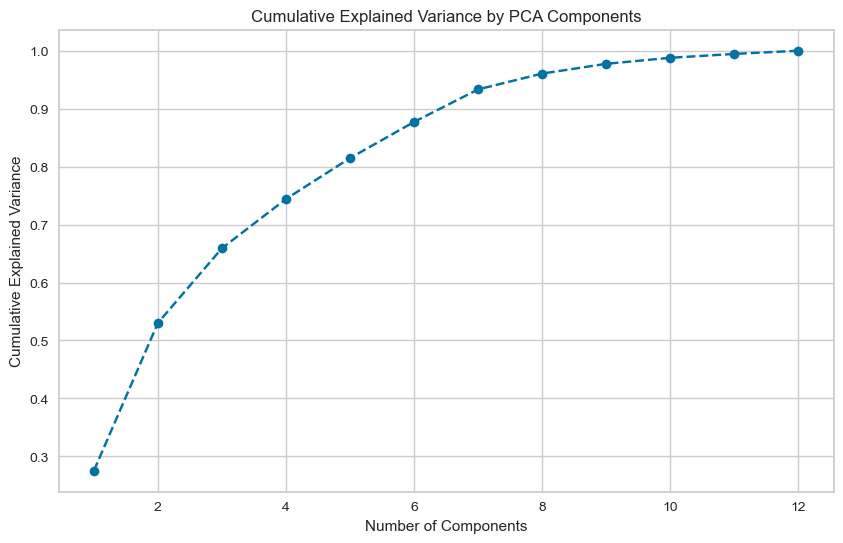

In [ ]:
#PCA
# Dropping the CustomerID column as it's not needed for clustering
features = scaled_customer_df.drop('CustomerID', axis=1)

# Applying PCA
pca = PCA()
pca_features = pca.fit_transform(features)

# Percentage of variance explained by each of the selected components
explained_variance = pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_explained_variance = explained_variance.cumsum()

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

The cumulative explained variance plot above illustrates the proportion of the dataset’s total variance that is captured by each successive principal component. As we move from the first to the twelfth component, the cumulative variance increases, indicating that each component adds some new information. The curve's steepness reduces after the sixth component(captures more than 85% of the tot variance), suggesting diminishing returns on variance explained with the addition of further components. This observation can guide the choice to retain the first six components for further analysis, such as K-means clustering, as they encompass the majority of the variance, thereby providing a comprehensive but simplified representation of the original dataset.

In [ ]:
# 'features.columns' will automatically include all the features used in PCA
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(pca.components_))], index=features.columns)

# Display the loadings
print(loadings)

                               PC1       PC2       PC3       PC4       PC5  \
TotalCustomerSpend        0.458606  0.106315 -0.061226  0.228934 -0.001116   
PurchaseFrequency         0.432770  0.095751  0.213681  0.047204 -0.273101   
AverageSpendPerVisit      0.156649  0.049356 -0.456258  0.244705  0.557505   
ProductVariety            0.199082 -0.045032 -0.385066 -0.487333  0.347123   
TimeSinceLastPurchase    -0.253217 -0.044444  0.005035  0.113118  0.387261   
MostCommonPurchaseDay     0.188934 -0.971548  0.089928  0.098539  0.034968   
MostCommonPurchaseHour   -0.002607 -0.067817 -0.108484 -0.673338 -0.151267   
NumCancellations          0.260705  0.089090  0.476140 -0.178945  0.305097   
TotalTransactions         0.426737  0.028850 -0.101650 -0.256352 -0.075901   
CancellationRate          0.036849  0.070072  0.575176 -0.132803  0.469366   
Is_UK                     0.004660 -0.006135  0.010747 -0.020942 -0.015121   
Total_Products_Purchased  0.432371  0.104250 -0.079240  0.237241

**EXPLENATION OF THE PCA COMPONENTS**

PC1: "Overall Engagement":
- Highly Influenced By: TotalCustomerSpend, PurchaseFrequency, TotalTransactions, and Total_Products_Purchased.
- Interpretation: This component primarily reflects overall customer engagement with the store. High scores on PC1 likely indicate customers who spend more, purchase frequently, and have a higher total number of transactions and products purchased. This could represent a segment of highly engaged or high-value customers.

PC2: "Purchase Timing Preference":
- Interpretation: Given its strong negative loading on the day of the week, PC2 may differentiate customers based on their preferred shopping days, separating weekend shoppers from weekday shoppers.
- Highly Influenced By: MostCommonPurchaseDay with a significant negative loading.

PC3: "Cancellation Propensity":
- Highly Influenced By: CancellationRate and NumCancellations positively, and AverageSpendPerVisit negatively.
- Interpretation: This component seems to capture the tendency toward order cancellations. Customers with high scores on PC3 may be more likely to cancel, and this propensity is inversely related to their average spend per visit, indicating that customers who spend less per visit may cancel more.

PC4: "Shopping Hour Preference":
- Highly Influenced By: MostCommonPurchaseHour negatively.
- Interpretation: PC4 could be distinguishing customers based on the time of day they prefer to make purchases, with negative loadings indicating a preference for shopping later in the day.

PC5: "High Spend on Few Visits":
- Influences: Positively by AverageSpendPerVisit and CancellationRate.
- Interpretation: Customers who score high on this component might spend a lot in fewer visits and have a relatively higher cancellation rate. This might represent customers making significant purchases but not very frequently, possibly indicative of more deliberate, high-value shopping trips that are occasionally reconsidered.

PC6: "Time Since Last Purchase and Visit Time Variation":
- Influences: Positively by TimeSinceLastPurchase and MostCommonPurchaseHour.
- Interpretation: This component may reflect customers' recency of purchase and their variability in shopping hours. High scores could indicate customers who have not purchased recently but, when they do, their shopping hours vary widely.

In [ ]:
# Selecting the number of components that explain at least 80% of the variance
pca_components = 6
pca_features_six = pca_features[:, :pca_components]

pca_features_six = pd.DataFrame(pca_features_six, columns=[f'PC{i}' for i in range(1, pca_components + 1)])
pca_features_six.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,4.364417,1.755053,4.738494,-1.544923,1.599520,0.243435
1,-1.110731,2.492761,0.135012,1.193291,-0.658560,-0.800503
2,3.553525,1.370600,1.635156,-0.349371,-1.072096,2.000764
3,8.167338,3.608913,5.912330,-1.369564,1.187115,0.413259
4,3.232547,-0.723233,0.517289,0.736561,-0.885620,1.920084


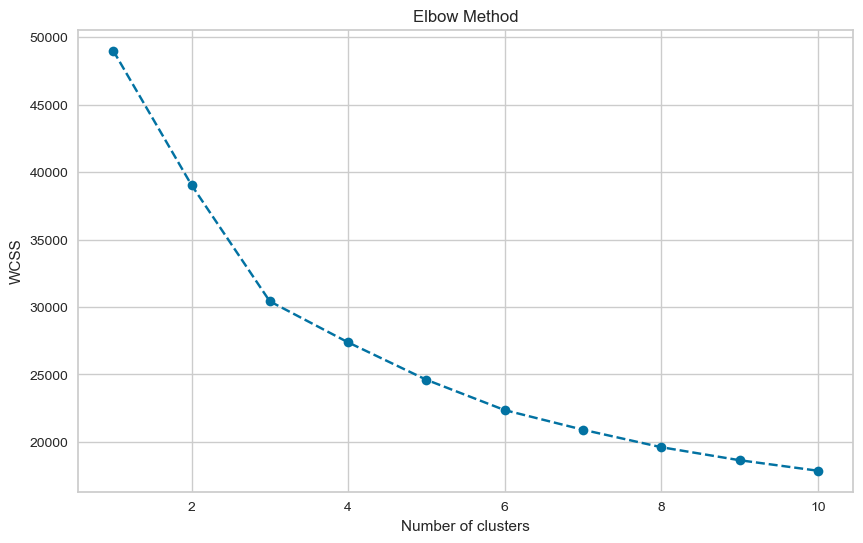

In [ ]:
#Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(pca_features_six)
    wcss.append(kmeans.inertia_)

# Plot the WCSS to find the elbow
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Since the elebow is not very pronounced we can calculate the silhouette score for different numbers of clusters to find which clustering solution has the highest average silhouette score. This measure will provide insight into the distance between the resulting clusters.

/Users/fabriziorigodanzo/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 3, the average silhouette score is : 0.2424494691623725


/Users/fabriziorigodanzo/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 4, the average silhouette score is : 0.25345027601110093


/Users/fabriziorigodanzo/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5, the average silhouette score is : 0.20958074187095466


/Users/fabriziorigodanzo/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6, the average silhouette score is : 0.21540031220154496


/Users/fabriziorigodanzo/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 7, the average silhouette score is : 0.21879063585872507


/Users/fabriziorigodanzo/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 8, the average silhouette score is : 0.20118675607716557


/Users/fabriziorigodanzo/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 9, the average silhouette score is : 0.20477484265831206


/Users/fabriziorigodanzo/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 10, the average silhouette score is : 0.20546267464059254


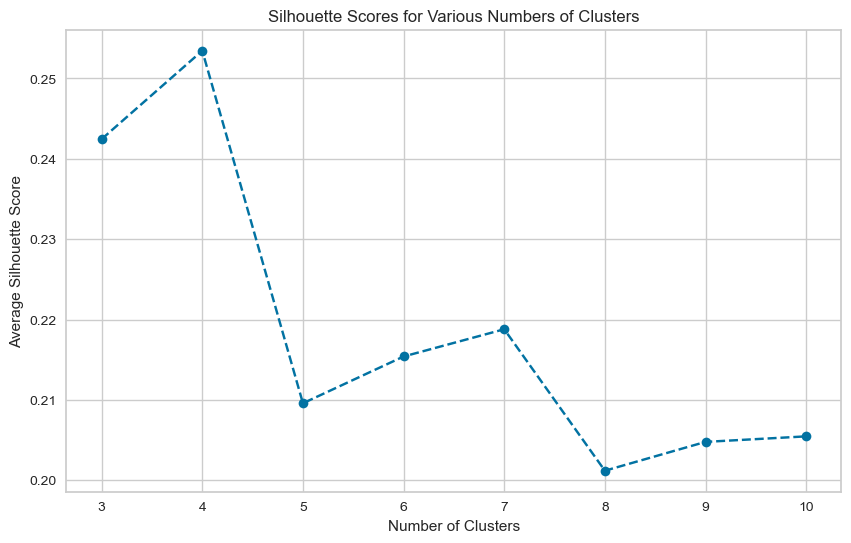

In [ ]:
# Range of clusters to try (e.g., 3 to 10)
range_n_clusters = list(range(3, 11))

# List to keep track of silhouette scores for each n_clusters
silhouette_avg_scores = []

# Loop through the range to calculate silhouette scores
for n_clusters in range_n_clusters:
    # Initialize KMeans with current number of clusters
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    # Fit the model
    cluster_labels = clusterer.fit_predict(pca_features_six)
    
    # Calculate the silhouette score and append it to the list
    silhouette_avg = silhouette_score(pca_features_six, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is : {silhouette_avg}")

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg_scores, marker='o', linestyle='--')
plt.title('Silhouette Scores for Various Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.show()

The silhouette scores in the graph indicate that a 4-cluster solution yields the strongest separation and cohesion. Yet, to evaluate our clusters thoroughly and achieve a finer understanding of our customer base, we've decided to visualize the segmentation in 3D. 

/Users/fabriziorigodanzo/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The average silhouette score for K-Means with 3 clusters: 0.25345027601110093


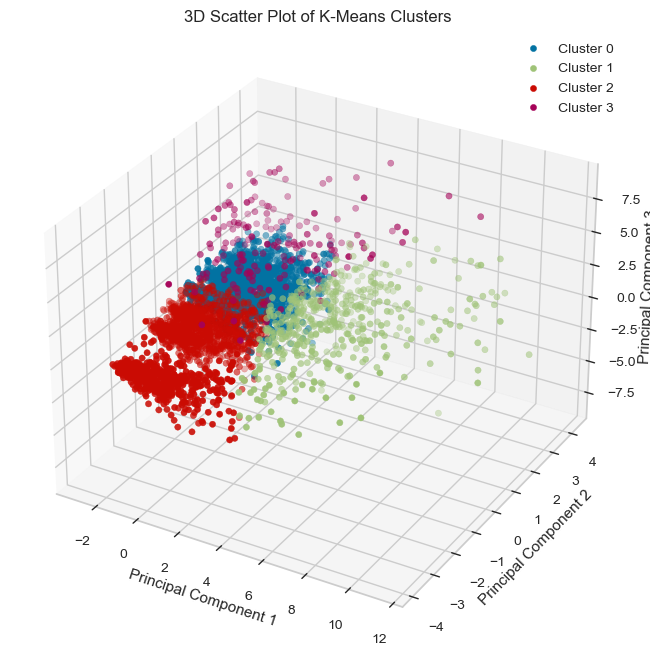

In [ ]:
# and 'Cluster' is the column with cluster labels obtained from K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(pca_features_six.iloc[:, :6])  # Fit K-Means using only the six principal components
pca_features_six['Cluster'] = kmeans.labels_  # Add the cluster labels to your PCA DataFrame

# Calculate silhouette score
silhouette_avg = silhouette_score(pca_features_six.iloc[:, :6], pca_features_six['Cluster'])
print(f'The average silhouette score for K-Means with 3 clusters: {silhouette_avg}')

# Now create the 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster with a different color
for cluster in range(4):
    # Get data points that belong to the current cluster
    cluster_data = pca_features_six[pca_features_six['Cluster'] == cluster]
    ax.scatter(cluster_data['PC1'], cluster_data['PC2'], cluster_data['PC3'], label=f'Cluster {cluster}')

# Labeling the axes
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Title and legend
ax.set_title('3D Scatter Plot of K-Means Clusters')
ax.legend()

# Show the plot
plt.show()

/Users/fabriziorigodanzo/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The average silhouette score for K-Means with 3 clusters: 0.2424494691623725


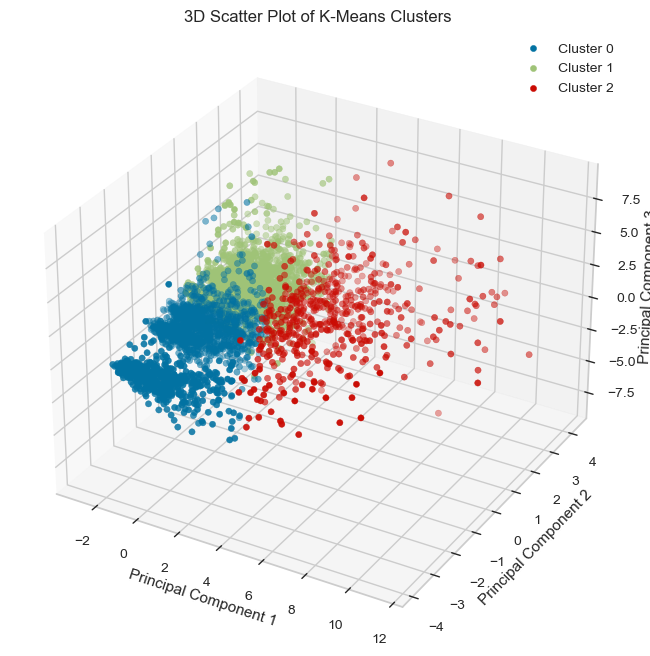

In [ ]:
# and 'Cluster' is the column with cluster labels obtained from K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(pca_features_six.iloc[:, :6])  # Fit K-Means using only the six principal components
pca_features_six['Cluster'] = kmeans.labels_  # Add the cluster labels to your PCA DataFrame

# Calculate silhouette score
silhouette_avg = silhouette_score(pca_features_six.iloc[:, :6], pca_features_six['Cluster'])
print(f'The average silhouette score for K-Means with 3 clusters: {silhouette_avg}')

# Now create the 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster with a different color
for cluster in range(3):
    # Get data points that belong to the current cluster
    cluster_data = pca_features_six[pca_features_six['Cluster'] == cluster]
    ax.scatter(cluster_data['PC1'], cluster_data['PC2'], cluster_data['PC3'], label=f'Cluster {cluster}')

# Labeling the axes
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Title and legend
ax.set_title('3D Scatter Plot of K-Means Clusters')
ax.legend()

# Show the plot
plt.show()

After conducting K-Means clustering with both three and four clusters and examining the respective 3D scatter plots, we've observed that the three-cluster solution provides a clearer and more meaningful segmentation of the data. While the four-cluster model resulted in some overlapping and less distinguishable groupings, reducing the number to three has enhanced the distinctiveness and separation of each cluster. This improved delineation aligns with our objective to create well-defined customer segments that can inform targeted marketing strategies and personalized customer engagement.

In [ ]:
# Calculate the mean of each attribute in the customer dataframe for each cluster
cluster_profile = pca_features_six.groupby('Cluster').mean()

# Optionally, calculate the standard deviation to see the spread of the attributes within each cluster
cluster_profile_std = pca_features_six.groupby('Cluster').std()

print("Cluster Profiles (Means):")
print(cluster_profile)

print("\nCluster Profiles (Standard Deviations):")
print(cluster_profile_std)

Cluster Profiles (Means):
              PC1       PC2       PC3       PC4       PC5       PC6
Cluster                                                            
0       -0.259348 -1.675582  0.055872  0.059168  0.023403  0.013257
1       -0.863891  1.403514 -0.120090 -0.088512 -0.018204 -0.082737
2        3.895547  0.854316  0.226626  0.105416 -0.016804  0.242590

Cluster Profiles (Standard Deviations):
              PC1       PC2       PC3       PC4       PC5       PC6
Cluster                                                            
0        1.089392  1.231589  1.063007  0.951032  0.840796  0.890731
1        0.999545  0.837643  1.253925  0.951889  0.954463  0.834131
2        1.949087  1.538292  2.071976  1.662611  1.391905  1.199728


PC1: "Overall Engagement"
PC2: "Purchase Timing Preference"
PC3: "Cancellation Propensity":
PC4: "Shopping Hour Preference":
PC5: "High Spend on Few Visits":
PC6: "Time Since Last Purchase and Visit Time Variation":

Cluster 0 - "Weekend Window Shoppers":
- Characteristics: Lower overall engagement (PC1), a strong preference for shopping on specific days (PC2), and moderate cancellation propensity (PC3).
- Behavior: This cluster tends to visit the store mostly on weekends. Their engagement is lower, suggesting they might be casual shoppers who browse more than they buy. Their purchase patterns are relatively predictable, with moderate variability in their shopping behavior.

Cluster 1 - "Erratic Midweek Shoppers":
- Characteristics: The most negatively affected by overall engagement (PC1) with a particular preference for midweek shopping (PC2).
- Behavior: This group is characterized by the least frequent and least amount of spending, but they prefer to shop during weekdays. They have the least variability in purchase timing (PC4) but are also somewhat prone to cancellations (PC3).

Cluster 2 - "Engaged, Flexible Shoppers":
- Characteristics: Highly engaged (PC1), not as affected by the day of the week (PC2), higher propensity for cancellations (PC3), and significant variation in shopping hours (PC6).
- Behavior: This segment is the most engaged, with high spending and purchasing frequency. They are more indifferent to the day of the week, suggesting they are regular customers. Despite this, they exhibit a higher tendency towards cancellations and have varied shopping hours, indicating flexibility or unpredictability in their shopping schedule.

The standard deviations show that there is significant variability within each cluster, particularly in Cluster 2, which could indicate a diverse set of behaviors within that group. This variability should be considered when tailoring marketing strategies to ensure they resonate with as many subgroup characteristics as possible within each cluster.

#### P2.2 Build a second model to segment costumers and compare the performance. (10 points)

Hierarchical Clustering as a Second Model

In our quest to refine customer segmentation, we chose hierarchical clustering as our second model to contrast with the K-means baseline. Hierarchical clustering is an exploratory data analysis method that builds a hierarchy of clusters strategies such as agglomerative ("bottom-up") approach, which starts with each element as a separate cluster and merges them into successively larger clusters.

Potential Performance Benefits:

- **Better at Identifying Varied Cluster Sizes**: Hierarchical clustering can perform better than K-means in identifying clusters of different sizes and densities, which can be closer to the natural distribution of the data.

- **Capturing Hierarchical Relationships**: For businesses with hierarchical relationships within the customer base, such as varying loyalty levels, hierarchical clustering can naturally reflect these relationships.

- **Robustness to Initial Conditions**: K-means clustering results can vary based on the initial centroid positions (which can be mitigated by setting a `random_state`), but hierarchical clustering provides a unique, deterministic set of clusters, making the model more stable and reproducible.

While hierarchical clustering has its advantages, it also comes with computational constraints, particularly for large datasets. Nevertheless, it serves as a robust alternative to K-means, offering potentially more insightful and nuanced customer segmentation.

/Users/fabriziorigodanzo/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


The average silhouette score for hierarchical clustering is : 0.240478825388045


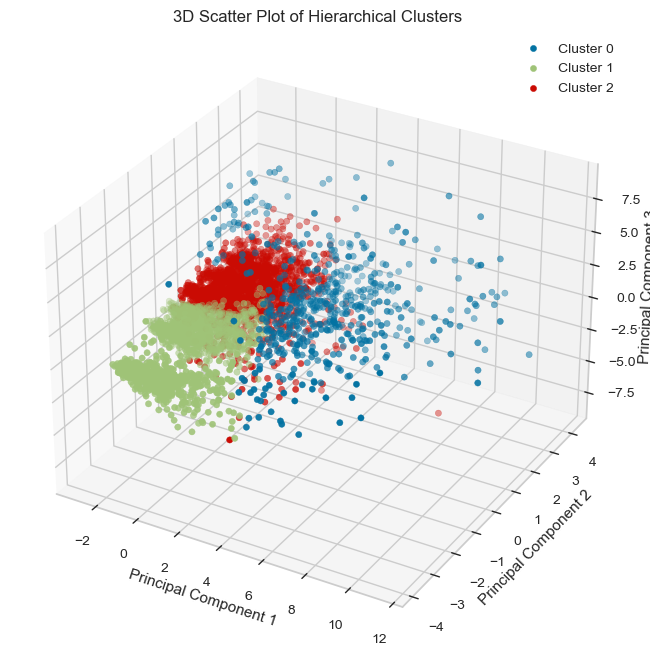

In [ ]:
# Apply hierarchical clustering to the first three principal components 
hierarchical_model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
hierarchical_labels = hierarchical_model.fit_predict(pca_features_six)

silhouette_avg_hierarchical = silhouette_score(pca_features_six, hierarchical_labels)
print(f"The average silhouette score for hierarchical clustering is : {silhouette_avg_hierarchical}")

#plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster with a different color
for cluster in range(3):
    # Get data points that belong to the current cluster
    cluster_data = pca_features_six[hierarchical_labels == cluster]
    ax.scatter(cluster_data['PC1'], cluster_data['PC2'], cluster_data['PC3'], label=f'Cluster {cluster}')

# Labeling the axes
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Title and legend
ax.set_title('3D Scatter Plot of Hierarchical Clusters')
ax.legend()


**CLUSTERS EVALUATION**

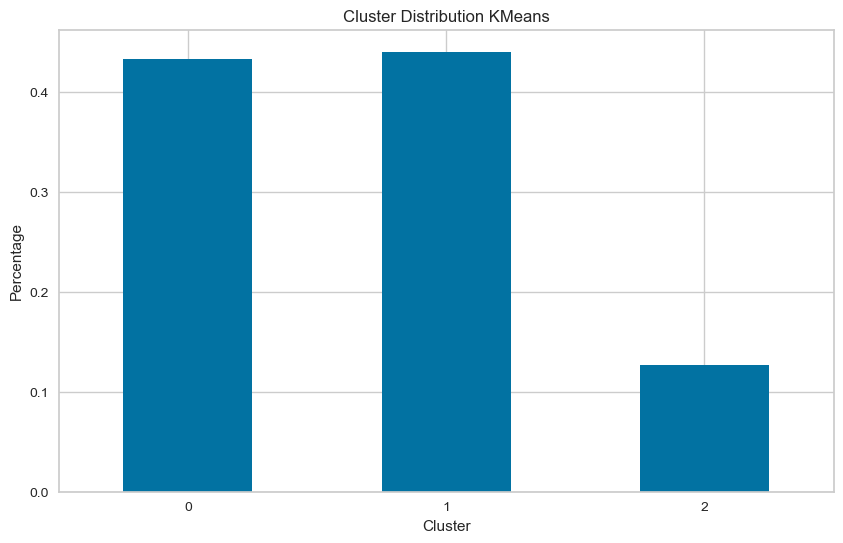

In [ ]:
#cluster distribution 
cluster_distribution = pca_features_six['Cluster'].value_counts(normalize=True).sort_index()

#plot the cluster distribution
plt.figure(figsize=(10, 6))
cluster_distribution.plot(kind='bar')
plt.title('Cluster Distribution KMeans')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

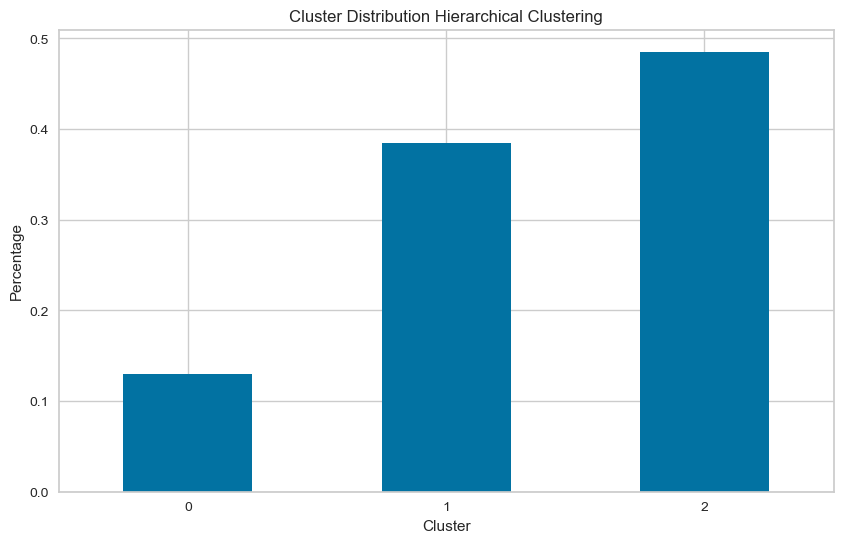

In [ ]:
pca_features_six['Cluster2'] = hierarchical_labels
#cluster distribution 
cluster_distribution = pca_features_six['Cluster2'].value_counts(normalize=True).sort_index()

#plot the cluster distribution
plt.figure(figsize=(10, 6))
cluster_distribution.plot(kind='bar')
plt.title('Cluster Distribution Hierarchical Clustering')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()


After applying two distinct clustering approaches, K-Means and Hierarchical Clustering, to our PCA-transformed customer data, we are presented with two varied perspectives on customer segmentation. The cluster distribution plots for both methods reveal key differences in cluster balance. K-Means clustering results in a more even distribution of customers across the three segments, which could be more desirable for a recommendation system. A balanced distribution ensures that the recommendations are not biased toward a particular segment's preferences, providing a more egalitarian approach that could cater to a broader range of customer behaviors and preferences. On the other hand, Hierarchical Clustering shows a slightly more skewed distribution, which might lead to more niche insights for specific customer groups but may also risk overlooking the broader customer base. Given the objective of our recommendation system to provide comprehensive and varied suggestions, the balanced cluster sizes resulting from K-Means clustering might serve our purposes more effectively, ensuring no single cluster disproportionately influences the recommendations

In [ ]:
customer_df['Cluster'] = kmeans.labels_
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4143 entries, 1 to 4361
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CustomerID                4143 non-null   float64
 1   TotalCustomerSpend        4143 non-null   float64
 2   PurchaseFrequency         4143 non-null   int64  
 3   AverageSpendPerVisit      4143 non-null   float64
 4   ProductVariety            4143 non-null   float64
 5   TimeSinceLastPurchase     4143 non-null   int64  
 6   MostCommonPurchaseDay     4143 non-null   int64  
 7   MostCommonPurchaseHour    4143 non-null   int64  
 8   NumCancellations          4143 non-null   float64
 9   TotalTransactions         4143 non-null   int64  
 10  CancellationRate          4143 non-null   float64
 11  Is_UK                     4143 non-null   int64  
 12  Total_Products_Purchased  4143 non-null   int64  
 13  Cluster                   4143 non-null   int32  
dtypes: float

In [ ]:
#CLUSTERS DESCRIPTION
#Calculate Statistical Summaries for Each Cluster (Mean and Standard Deviation) of all the Features
cluster_means = customer_df.groupby('Cluster').mean()
cluster_std = customer_df.groupby('Cluster').std()

# Print the means to get an idea of the central tendency of each attribute within each cluster
print("Cluster Means:")
print(cluster_means)

# Print the standard deviations to understand the variability within each cluster
print("\nCluster Standard Deviations:")
print(cluster_std)

Cluster Means:
           CustomerID  TotalCustomerSpend  PurchaseFrequency  \
Cluster                                                        
0        15295.532033          723.681582           2.879109   
1        15381.624452          732.742133           2.922149   
2        15337.421756         4101.888492          12.345420   

         AverageSpendPerVisit  ProductVariety  TimeSinceLastPurchase  \
Cluster                                                                
0                  268.862288       23.288531             103.032869   
1                  278.542410       21.579855             101.926535   
2                  409.147712       34.186122              23.849237   

         MostCommonPurchaseDay  MostCommonPurchaseHour  NumCancellations  \
Cluster                                                                    
0                     5.143175               12.708635          0.648468   
1                     2.002193               12.339912          0.720395   

#### P2.3 Based on the analysis, suggest a number of clusters and their characteristics to the head of marketing.